In [23]:
import pandas as pd
import numpy as np 
import json
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

cameo_to_penta = {
    "Make Public Statement" : "Make a statement",
    "Appeal" : "Verbal Cooperation",  	#Statement?
    "Express Intend to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation",  #Verbal?
    "Investigate" : "Material Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Verbal Conflict", #Material?
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict"
}

In [3]:
os.chdir("..")
#for pretrain data
data = pd.read_csv("soft_data/data/out_data/entail_articles_url_coref3.csv.done.csv", index_col = 0)
data.shape

(2601, 2)

In [11]:
#only needed up until coref3
#data["label"] = data.label.apply(lambda x: x.replace("Intend", "Express Intend to Cooperate"))

In [12]:
data.head()

,text,label,rel_count,relations
0,11:44pm: UN grain coordinator expects loaded s...,<triplet> UN grain coordinator <subj> loaded s...,1,[Consult]
1,8:04pm: Pro-Moscow force renews evacuation of ...,"<triplet> which <subj> 70,000 people <obj> Yield",1,[Yield]
2,"""Wagner and its alleged boss Yevgeny Prigozhin...",<triplet> terror <subj> Ukraine <obj> Make Pub...,1,[Make Public Statement]
3,Finland and Sweden asked to join the NATO defe...,<triplet> Finland <subj> the NATO defence alli...,1,[Consult]
4,"In a post on Telegram, Vladimir Saldo, the Rus...",<triplet> civilians <subj> an additional 15 ki...,1,[Reduce Relations]


# General EDA

In [13]:
#How many relations does each text have?
data["rel_count"] = data.label.apply(lambda x: x.count("<triplet>"))
for count in range(data.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {data[data.rel_count == count + 1].shape[0]}")

#almost all sentences only have 1 relation

Count of sentences with 1 relations: 2518
Count of sentences with 2 relations: 82
Count of sentences with 3 relations: 1


<AxesSubplot: xlabel='text_len'>

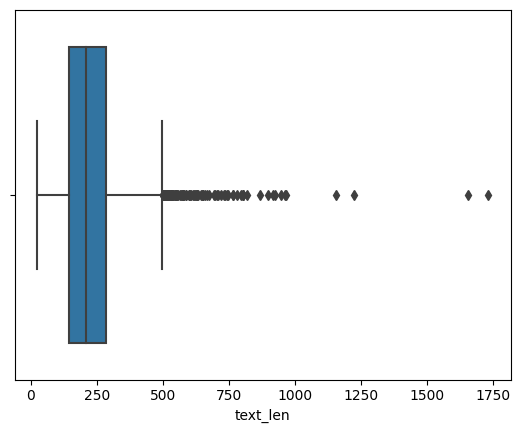

In [31]:
data["text_len"] = data.text.apply(lambda x: len(x))
sns.boxplot(x = data.text_len)

#there is an unsreasonable amount of data with very long texts.
#this might be a problem, since most text are sentences.
#500 seems like a reasonable cut-off to have data more uniform

# EDA with CAMEO codes

In [14]:
#extract the categorized relation
relation = []
for row in data.iterrows():
    sub_rels = []
    for cameo in cameo_to_penta.keys():
        for count in range(row[1]["label"].count(cameo)):
            sub_rels.append(cameo)
    relation.append(sub_rels)
data["relations"] = relation      

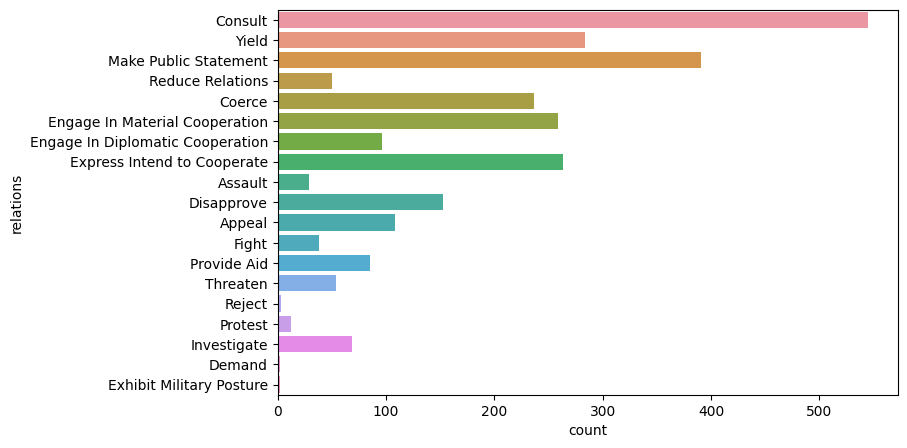

In [29]:
#enlargen dataframe so we have one row per relation instead of text with multiple relations
expl = data.explode("relations")
fig = plt.figure(figsize = (8,5))
sns.countplot(y = expl.relations);
#the data experiences a strong inbalance 
#the relation "engage in unconventional mass violence" was not used at all

# EDA with Pentacodes

In [34]:
penta_map = []
last_txt = ""
for row in data.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text])
penta = pd.DataFrame(penta_map, columns = ["text","label"])

In [37]:
penta_opts = ["Make a statement", "Verbal Cooperation", "Material Cooperation", "Verbal Conflict", "Material Conflict"]
#extract the categorized relation
relation = []
for row in penta.iterrows():
    sub_rels = []
    for opt in penta_opts:
        for count in range(row[1]["label"].count(opt)):
            sub_rels.append(opt)
    relation.append(sub_rels)
penta["relations"] = relation  

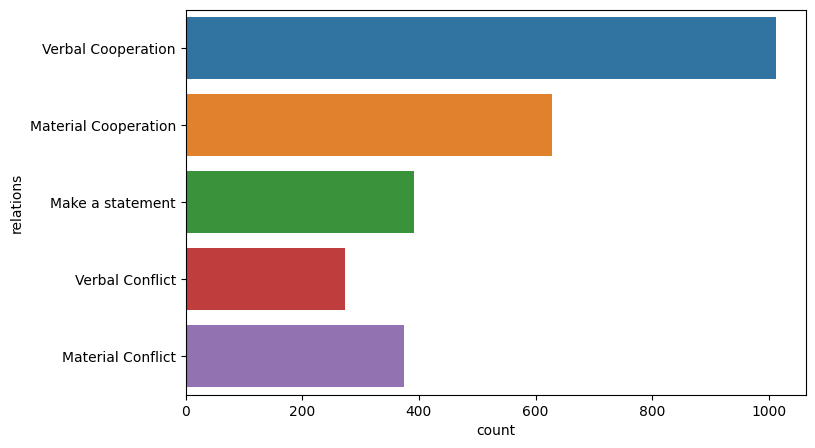

In [39]:
#enlargen dataframe so we have one row per relation instead of text with multiple relations
expl_penta = penta.explode("relations")
fig = plt.figure(figsize = (8,5))
sns.countplot(y = expl_penta.relations);
#generally more balanced than the CAMEO scores, but strongly focused on cooperation